# HW2 Playground

Fill in TODOs as you work through the assignment.
Implement the required sections in `model.py`, and use this notebook to orchestrate and run your solution.

In [189]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from hw2_loader import HW2DataLoader
from model import GradientBoostingModel, Hw1Classifier

#my own imports
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
# TODO: Load both datasets
loader = HW2DataLoader()

# Heart disease dataset
heart_path = Path('../data/heart.csv')
X_heart, y_heart = loader.get_heart_disease_data(csv_path=heart_path)
print(X_heart.shape, y_heart.value_counts().to_dict())

# Cancer genomics dataset
cancer_path = Path('../data/cancer_genomics.csv')
labels_path = Path('../data/labels_cancer_genomics.csv')
X_cancer, y_cancer = loader.get_cancer_genomics_data(
    csv_path=cancer_path, labels_path=labels_path
)
print(X_cancer.shape, y_cancer.value_counts().to_dict())


Successfully loaded heart disease data with 1025 rows
(1025, 13) {1: 526, 0: 499}
(801, 5479) {'BRCA': 300, 'KIRC': 146, 'LUAD': 141, 'PRAD': 136, 'COAD': 78}


In [191]:
#ENCODING LABELS AS NUMBERS
le = LabelEncoder()
y_heart = pd.Series(le.fit_transform(y_heart), name=y_heart.name)
y_cancer = pd.Series(le.fit_transform(y_cancer), name=y_cancer.name)

# Heart Data

In [192]:
#DEDUPLICATION

print('Number of duplicates:', X_heart.duplicated().sum())
dupl_indices = X_heart[X_heart.duplicated()].index.to_list()
X_heart = X_heart.drop(dupl_indices)
y_heart = y_heart.drop(dupl_indices)
print(len(X_heart))
print(len(y_heart))

Number of duplicates: 723
302
302


In [193]:
# #PREPROCESSING

# #Outliers
# from scipy import stats
# outliers = set()
# for col in X_heart.columns:
#     z = np.abs(stats.zscore(X_heart[col]))
#     outlier_threshold = 3
#     outlier_inds = np.where(z>outlier_threshold)[0]
#     print(col, "number of outliers:", len(outlier_inds))
#     outliers.update(outlier_inds)

# shape_before = X_heart.shape
# X_heart = X_heart.drop(outliers)
# y_heart = y_heart.drop(outliers)
# shape_after = X_heart.shape

# print('number of datapoints removed:', shape_before[0]-shape_after[0])

In [194]:
# TODO: Initialize your model (adjust params)
model = GradientBoostingModel(
    task='classification',
    max_depth = 5,
    learning_rate = 0.05,
    n_estimators = 100,
    subsample=1,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=7,
    random_state=42,
    use_scaler=True
)


In [ ]:
# TODO: Train/test split + fit (heart)
X_train, X_test, y_train, y_test = model.train_test_split(X_heart, y_heart, random_state=42)
model.fit(X_train, y_train, False)


In [196]:
# TODO: Evaluate (heart)
# metrics = model.evaluate(...)
# print metrics
metrics = model.evaluate(X_test, y_test)
print(metrics)

{'accuracy': 0.7540983606557377, 'precision': 0.7647058823529411, 'recall': 0.7878787878787878, 'f1': 0.7761194029850746, 'roc_auc': 0.8214285714285714}


In [197]:
# TODO: Cross-validation (heart)
# cv_results = model.cross_validate(...)
# print metrics
cv_results = model.cross_validate(X_heart, y_heart)
cv_df = pd.DataFrame(cv_results)
cv_df.index  = ['mean', 'stdev']
cv_df

,accuracy,precision,recall,f1,roc_auc
mean,0.831093,0.835239,0.860038,0.846611,0.887636
stdev,0.034074,0.028673,0.052323,0.031467,0.037432


In [198]:
# TODO: Feature importance (heart)
# model.get_feature_importance(plot=False)
feature_importance = model.get_feature_importance(False)
print('TOP FEATURES VIA GRADIENT BOOSTING')
print(feature_importance.head(10))

# k-feature selection via variance (HW1 method)
vars = np.var(X_heart, axis=0)
vars = vars.sort_values(ascending=False)
print('\n')
print('TOP FEATURES VIA LOGISTIC REGRESSION & VARIANCE')
print(vars.head(10))

TOP FEATURES VIA GRADIENT BOOSTING
   features  importance
0        cp    0.245067
1      thal    0.141195
2        ca    0.109876
3   thalach    0.086848
4      chol    0.077512
5   oldpeak    0.076705
6  trestbps    0.068721
7       age    0.066633
8       sex    0.046647
9     exang    0.037037


TOP FEATURES VIA LOGISTIC REGRESSION & VARIANCE
chol        2669.554636
thalach      522.834569
trestbps     307.451384
age           81.594678
oldpeak        1.344505
cp             1.061587
ca             1.010186
slope          0.378536
thal           0.374556
restecg        0.275788
dtype: float64


In [199]:
# TODO: Hyperparameter tuning (heart)
param_grid = {
    'max_depth': [5,8,12],
    'n_estimators': [25,50,100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_features': [7,10,13]
    # 'min_samples_split': [1,2,3],
    # 'min_samples_leaf': [1,2,3],
    # 'max_features': [5,10,15],
}
tuning_results = model.tune_hyperparameters(X_heart, y_heart, param_grid, cv=3)
print(tuning_results['best_params'])
print(tuning_results['best_score'])


{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 7, 'n_estimators': 100}
0.8978358463865709


In [200]:
# table
cv_results = model.tune_hyperparameters(X_heart, y_heart, param_grid, cv=3, plot=True)
df_results = pd.DataFrame(cv_results['params'])
df_results['mean test score'] = cv_results['mean_test_score']
df_results

,learning_rate,max_depth,max_features,n_estimators,mean test score
0,0.05,5,7,25,0.882394
1,0.05,5,7,50,0.889157
2,0.05,5,7,100,0.892788
3,0.05,5,10,25,0.875423
4,0.05,5,10,50,0.883397
...,...,...,...,...,...
76,0.20,12,10,50,0.852082
77,0.20,12,10,100,0.864076
78,0.20,12,13,25,0.770592
79,0.20,12,13,50,0.774862


# Cancer

In [201]:
# VISUALIZING DATA
print('Number of samples:', len(X_cancer))
print('Number of features:', len(X_cancer.columns))
print("Class balance:", y_cancer.value_counts().to_dict())

print('Number of missing values:', sum(X_cancer.isna().sum()))

Number of samples: 801
Number of features: 5479
Class balance: {0: 300, 2: 146, 3: 141, 4: 136, 1: 78}
Number of missing values: 0


In [202]:
#DEDUPLICATION

print('Number of duplicates:', X_cancer.duplicated().sum())
dupl_indices = X_cancer[X_cancer.duplicated()].index.to_list()
X_cancer = X_cancer.drop(dupl_indices)
y_cancer = y_cancer.drop(dupl_indices)
print(len(X_cancer))
print(len(y_cancer))

Number of duplicates: 0
801
801


In [203]:
# # PREPROCESSING

# #OUTLIERS
# outliers = set()
# for col in X_cancer.columns:
#     z = np.abs(stats.zscore(X_cancer[col]))
#     outlier_threshold = 3
#     outlier_inds = np.where(z>outlier_threshold)[0]
#     outliers.update(outlier_inds)

# shape_before = X_cancer.shape
# X_cancer = X_cancer.drop(outliers)
# y_cancer = y_cancer.drop(outliers)
# shape_after = X_cancer.shape

# print('number of datapoints removed:', shape_before[0]-shape_after[0])

In [204]:
# TODO: Train/evaluate on cancer dataset (multi-class)
# cancer_model = GradientBoostingModel(...)
# cancer_model.train_test_split(...)
# fit
# evaluate 
# print metrics

In [ ]:
cancer_model = GradientBoostingModel(
    task='classification',
    max_depth = 5,
    learning_rate = 0.05,
    n_estimators = 50,
    subsample=1,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=7,
    random_state=42,
    use_scaler=True
)
X_train_c, X_test_c, y_train_c, y_test_c = cancer_model.train_test_split(X_cancer, y_cancer, random_state=42)


In [206]:
#Class balance in training and testing sets
print("Class balance (train):", y_train_c.value_counts().to_dict())
print("Class balance (test):", y_test_c.value_counts().to_dict())

Class balance (train): {0: 240, 2: 116, 3: 113, 4: 109, 1: 62}
Class balance (test): {0: 60, 2: 30, 3: 28, 4: 27, 1: 16}


In [207]:
cancer_model.fit(X_train_c, y_train_c, False)
cancer_metrics = cancer_model.evaluate(X_test_c, y_test_c)
print(cancer_metrics)

{'accuracy': 0.9813664596273292, 'precision': 0.9815371372173616, 'recall': 0.9813664596273292, 'f1': 0.9811987061061624, 'roc_auc': 0.9998598981926866}


<Axes: >

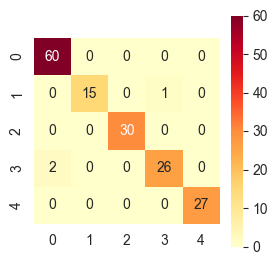

In [208]:
#CONFUSION MATRIX

y_pred = cancer_model.predict(X_test_c)

confusion = confusion_matrix(y_test_c, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(confusion, cmap='YlOrRd', annot=True, square=True, 
            )

In [209]:
# TODO: Cross-validation (cancer)
# cv_results = model.cross_validate(...)
# print metrics
cv_results = cancer_model.cross_validate(X_cancer, y_cancer)
cv_df = pd.DataFrame(cv_results)
cv_df.index  = ['mean', 'stdev']
cv_df

,accuracy,precision_weighted,recall_weighted,f1_weighted,roc_auc_ovr_weighted
mean,0.991266,0.991444,0.991266,0.991215,0.999981
stdev,0.006365,0.006290,0.006365,0.006413,0.000038


In [210]:
# TODO: Feature importance (cancer)
# model.get_feature_importance(plot=False)
feature_importance = cancer_model.get_feature_importance(False)
print('TOP FEATURES VIA GRADIENT BOOSTING')
print(feature_importance.head(10))

# k-feature selection via variance (HW1 method)
vars = np.var(X_cancer, axis=0)
vars = vars.sort_values(ascending=False)
print('\n')
print('TOP FEATURES VIA LOGISTIC REGRESSION & VARIANCE')
print(vars.head(10))

TOP FEATURES VIA GRADIENT BOOSTING
     features  importance
0   gene_7421    0.016668
1   gene_2845    0.014309
2   gene_3313    0.012757
3  gene_12078    0.011942
4   gene_8831    0.011833
5   gene_7490    0.011499
6  gene_12013    0.011198
7  gene_19542    0.010971
8   gene_9846    0.010680
9   gene_5821    0.010256


TOP FEATURES VIA LOGISTIC REGRESSION & VARIANCE
gene_9176     44.707964
gene_9175     36.316544
gene_15898    34.460838
gene_15301    33.417005
gene_15589    31.286736
gene_3540     30.549509
gene_19661    30.042925
gene_3541     28.685831
gene_11250    26.482784
gene_15897    25.986962
dtype: float64


In [217]:
# TODO: Hyperparameter tuning (cancer)
c_param_grid = {
    'max_depth': [5,8,12],
    'n_estimators': [25,50,100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_features': [7,10,13]
    # 'min_samples_split': [1,2,3],
    # 'min_samples_leaf': [1,2,3],
    # 'max_features': [5,10,15],
}
c_tuning_results = model.tune_hyperparameters(X_cancer, y_cancer, c_param_grid, cv=3, scoring='roc_auc_ovr')
print(c_tuning_results['best_params'])
print(c_tuning_results['best_score'])


{'learning_rate': 0.05, 'max_depth': 8, 'max_features': 7, 'n_estimators': 50}
1.0


## Compare w/ Hw1 (Cancer)

In [227]:
k = 10
selected_features = feature_importance['features'].iloc[0:k+1].tolist()

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cancer, y_cancer, stratify=y_cancer, random_state=42)

#FULL MODEL
logistic_model_full = Hw1Classifier()
logistic_model_full.fit(X_train_c, y_train_c)
full_metrics = logistic_model_full.evaluate(X_test_c, y_test_c)
full_df = pd.DataFrame(full_metrics, index=range(len(full_metrics)))
# print('full:', full_metrics)
print('all features')
print(full_df)

#TOP K FEATURES MODEL
logistic_model_k = Hw1Classifier(selected_features=selected_features)
logistic_model_k.fit(X_train_c, y_train_c)
k_metrics = logistic_model_k.evaluate(X_test_c, y_test_c)
# print('k:', k_metrics)
k_df = pd.DataFrame(k_metrics, index=range(len(k_metrics)))
print(f'{k} features')
print(k_df)


all features
   accuracy  precision   recall       f1   roc_auc
0   0.99005    0.99005  0.99005  0.99005  0.999855
1   0.99005    0.99005  0.99005  0.99005  0.999855
2   0.99005    0.99005  0.99005  0.99005  0.999855
3   0.99005    0.99005  0.99005  0.99005  0.999855
4   0.99005    0.99005  0.99005  0.99005  0.999855
10 features
   accuracy  precision    recall       f1   roc_auc
0  0.975124   0.976032  0.975124  0.97512  0.998968
1  0.975124   0.976032  0.975124  0.97512  0.998968
2  0.975124   0.976032  0.975124  0.97512  0.998968
3  0.975124   0.976032  0.975124  0.97512  0.998968
4  0.975124   0.976032  0.975124  0.97512  0.998968
